In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot

import plotly.express as px
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

# MNIST dataset

(load is broken so I got it in different way then desciribed in the book)

In [269]:
# X, y = fetch_openml('mnist_784', version=1, return_X_y=True)


In [270]:
X = pd.read_csv("/Users/darji/ml/datasets/mnist/mnist_X.csv").drop('Unnamed: 0', axis=1).values
X.shape

(70000, 784)

In [271]:
y = pd.read_csv("/Users/darji/ml/datasets/mnist/mnist_y.csv").drop('Unnamed: 0', axis=1).values.T[0]
y.shape

(70000,)

In [272]:
np.arange(10).shape

(10,)

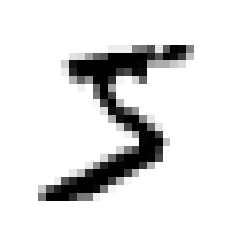

In [273]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [274]:
y = y.astype(np.uint8)

## Train - test split has been already preperformed

In [275]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary classifier

_Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task_

In [276]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [277]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [278]:
sgd_clf.predict([some_digit])

array([ True])

## Performance measure
### 1. Cross-validation

Implementing cross-validation by myself

In [280]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)


for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    
    
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    
    print((n_correct / len(y_pred)))  # prints 0.9502, 0.96565, and 0.96495

0.9669
0.91625
0.96785


In [281]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### 2. Confusion matrix

In [282]:
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # instead of returning the evaluation scores, 
                                                            # it returns the predictions made on each test fold
y_train_predict

array([ True, False, False, ...,  True, False, False])

In [283]:
from sklearn.metrics import confusion_matrix


# Each row in a confusion matrix represents an actual class, while each column represents a predicted class
confusion_matrix(y_train_5, y_train_predict)

array([[53892,   687],
       [ 1891,  3530]])

perfect classifier:

In [284]:
confusion_matrix(y_train_5, perfect:=y_train_5)

array([[54579,     0],
       [    0,  5421]])

### 2.b Precision and recall

In [285]:
from sklearn.metrics import precision_score as precision, recall_score as recall

In [286]:
for metrics, function in zip(("Precision", "Recall"), (precision, recall)):
    print(f"{metrics} score: {function(y_train_5, y_train_predict)}")

Precision score: 0.8370879772350012
Recall score: 0.6511713705958311


### 2.c F1 Score

In [292]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_predict)

0.7325171197343846

### 3 Precision-Recall curve
decision function with threshold = 0

In [293]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [295]:
threshold = 0
y_some_digit_prediction = (y_scores > threshold)
y_some_digit_prediction

array([ True])

In [296]:
threshold = 8000
y_some_digit_prediction = (y_scores > threshold)
y_some_digit_prediction

array([False])

How do you decide which threshold to use? First, use the ```cross_val_predict()``` function to get the scores of all instances in the training
set, but this time specify that you want to return __decision scores instead of predictions__

In [298]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [305]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

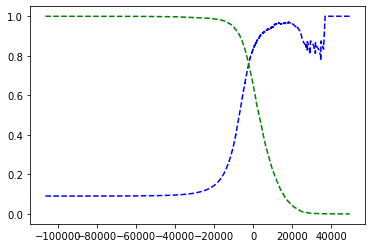

In [307]:
def plot_precision_recall_vs_threshold(precisions, recall, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g--", label="Recall")
    plt.show()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### 4 ROC curve

In [312]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [313]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    
    plt.show()

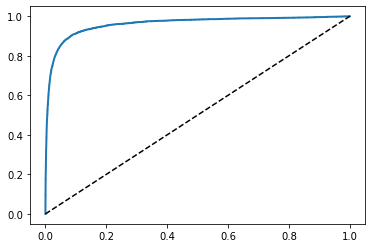

In [314]:
plot_roc_curve(fpr, tpr)

### 4.b AUC score

### _TIP_
Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-left
  

In [315]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

# Try Random forest classifier

The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5)

In [316]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [317]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [318]:
y_scores_forest = y_probas_forest[:, 1] # score = probability of the positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

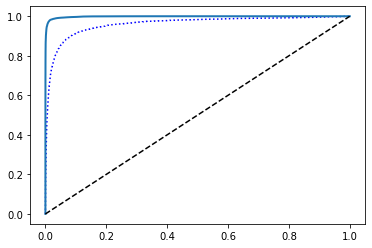

No handles with labels found to put in legend.


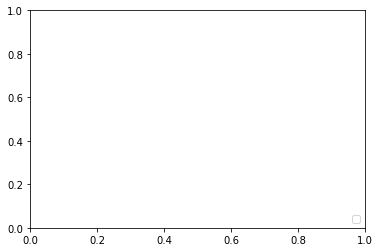

In [325]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [328]:
roc_auc_score(y_train_5, y_scores_forest) # - much better

0.9983436731328145

# Multiclass classification

In [329]:
from sklearn.svm import SVC
svm_clf = SVC()

svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [331]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [332]:
np.argmax(some_digit_scores)

5

In [333]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

## Force SKLearn to One-vs.-One or One-vs.-All classification

In [334]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
print(ovr_clf.predict([some_digit]))

print(len(ovr_clf.estimators_))

KeyboardInterrupt: 

In [335]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [344]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [337]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

# Scale the inputs

In [338]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [340]:
%time cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

CPU times: user 7min 48s, sys: 2.54 s, total: 7min 51s
Wall time: 7min 48s


array([0.8983, 0.891 , 0.9018])

In [343]:
ovr_clf.estimators_

AttributeError: 'OneVsRestClassifier' object has no attribute 'estimators_'

# Error analysis

In [345]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]])

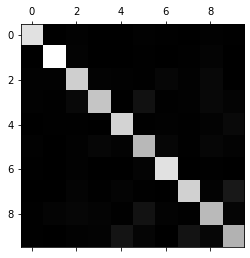

In [346]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

### See error rates instead of absolute values

In [353]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [359]:
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.51375992e-01, 0.00000000e+00, 1.02988350e-02, 1.68833361e-03,
        2.70133378e-03, 8.44166807e-03, 7.76633463e-03, 1.18183353e-03,
        1.11430019e-02, 5.40266757e-03],
       [4.44971818e-04, 9.48234945e-01, 1.40907743e-02, 3.11480273e-03,
        2.37318303e-03, 6.97122516e-03, 2.22485909e-03, 4.00474637e-03,
        1.61673094e-02, 2.37318303e-03],
       [1.20845921e-02, 9.39912722e-03, 8.68412219e-01, 1.49378986e-02,
        1.15810675e-02, 6.54582075e-03, 2.73581739e-02, 1.10775428e-02,
        3.55824102e-02, 3.02114804e-03],
       [9.46012070e-03, 5.21937694e-03, 3.53938999e-02, 8.05904420e-01,
        3.75142717e-03, 7.19295384e-02, 5.21937694e-03, 9.13390964e-03,
        3.52307943e-02, 1.87571359e-02],
       [1.88291681e-03, 4.45053064e-03, 7.87401575e-03, 1.02704553e-03,
        9.06881205e-01, 4.45053064e-03, 1.24957206e-02, 5.47757617e-03,
        1.48921602e-02, 4.05682985e-02],
       [1.25438111e-02, 4.24275964e-03, 1.06991330e-02, 2.76701716e-02,
   

Fill the diagonal with zeros to keep only the errors, and plot the result

In [360]:
np.fill_diagonal(norm_conf_mx, 0)
norm_conf_mx

array([[0.        , 0.        , 0.01029884, 0.00168833, 0.00270133,
        0.00844167, 0.00776633, 0.00118183, 0.011143  , 0.00540267],
       [0.00044497, 0.        , 0.01409077, 0.0031148 , 0.00237318,
        0.00697123, 0.00222486, 0.00400475, 0.01616731, 0.00237318],
       [0.01208459, 0.00939913, 0.        , 0.0149379 , 0.01158107,
        0.00654582, 0.02735817, 0.01107754, 0.03558241, 0.00302115],
       [0.00946012, 0.00521938, 0.0353939 , 0.        , 0.00375143,
        0.07192954, 0.00521938, 0.00913391, 0.03523079, 0.01875714],
       [0.00188292, 0.00445053, 0.00787402, 0.00102705, 0.        ,
        0.00445053, 0.01249572, 0.00547758, 0.01489216, 0.0405683 ],
       [0.01254381, 0.00424276, 0.01069913, 0.02767017, 0.01531083,
        0.        , 0.0320974 , 0.00479616, 0.02803911, 0.01494189],
       [0.00675904, 0.00219669, 0.00946266, 0.00101386, 0.00371747,
        0.01909429, 0.        , 0.00084488, 0.00608314, 0.00033795],
       [0.00367119, 0.00383081, 0.0164405

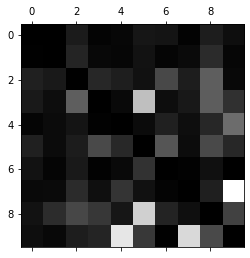

In [362]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [366]:
# cl_a, cl_b = 3, 5
# X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
# X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
# X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
# X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# plt.figure(figsize=(8,8))
# plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
# plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
# plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
# plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
# plt.show()

# Multilabel classification

In [375]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = y_train >= 7
y_train_odd = y_train % 2
y_multilabel = np.c_[y_train_large, y_train_odd] # array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8, or 9), and the second indicates whether or not it is odd

In [378]:
knn_clf = KNeighborsClassifier() # supports multilabel classification, though not all classifiers do
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [380]:
knn_clf.predict([some_digit]) # The digit 5 is indeed not large (False) and odd (True).

array([[0, 1]], dtype=uint8)

One approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. This code computes the average F1 score across all labels

In [382]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This assumes that all labels are equally important, however, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average="weighted" in the preceding code.

In [383]:
f1_score_score_score_score_score_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

# Multioutput Classification
 - simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values)
 # Sysetm noising and denoising

In [389]:
noise = np.random.randint(0, 100, X_train.shape)
noise

array([[87, 15, 98, ..., 35, 26, 12],
       [22, 61,  7, ..., 44, 11,  5],
       [88, 36, 56, ..., 21, 33, 29],
       ...,
       [14, 94, 57, ..., 72, 47, 89],
       [95, 68, 24, ..., 27,  5, 91],
       [ 8, 99, 41, ..., 59, 78, 91]])

In [390]:
X_train_mod = X_train + noise

In [392]:
noise = np.random.randint(0, 100, X_test.shape)
X_test_mod = X_test + noise

In [393]:
y_train_mod = X_train
y_test_mod = X_test

In [394]:
some_index = 12

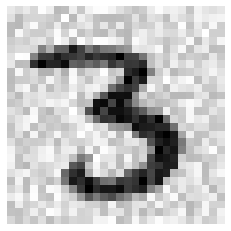

In [404]:
plt.imshow(X_train_mod[some_index].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

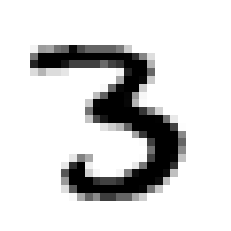

In [405]:
plt.imshow(X_train[some_index].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

In [408]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

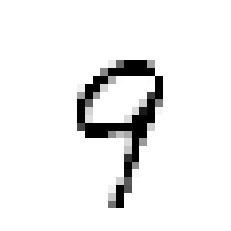

In [409]:
plt.imshow(clean_digit.reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

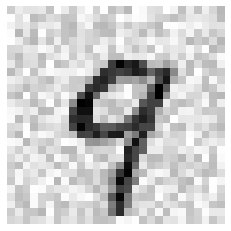

In [411]:
plt.imshow(X_test_mod[some_index].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

_________________________________________________























# EXCERCISES